In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from utils.train import *
from utils.dataloader import *
from utils.resnet import resnet34_andi, resnet18_andi

In [4]:
import random
random.seed(42)

dataset_size = 1 # Challenge 150
num_epochs = 100

device = "cuda"

# Dataset Preparation : Anomalous Exponent

In [5]:
X_dict = {f"{feat}":[] for feat in ["feat"]}
y_dict = {f"{feat}":[] for feat in ["a"]}

for i in tqdm(range(dataset_size)):

    X = np.load(f"./ds_single/ds_{i}.npy", allow_pickle=True)
    y = np.load(f"./ds_single/ds_label_{i}.npy", allow_pickle=True)

    ### TO Tensor
    X = torch.Tensor(X).squeeze().unsqueeze(axis=2).type(torch.Tensor)
    
    y_a = torch.Tensor(y[:,2])
    
    X_dict["feat"].append(X)
    y_dict["a"].append(y_a)

train_dataloader_dict = {f"{feat}":[] for feat in ["a"]}
valid_dataloader_dict = {f"{feat}":[] for feat in ["a"]}

g = torch.Generator()
g.manual_seed(42)

for feat in ["a"]:
    X = X_dict["feat"]
    y = y_dict[feat]
    X = torch.cat(X)
    y = torch.cat(y)
    dataset = AnDiDataset(X, y)

    # ## split
    train_set, val_set = torch.utils.data.random_split(dataset, [0.7, 0.3], generator=g)
    
    train_loader = DataLoader(train_set, batch_size=256, collate_fn=collate_fn, generator=g, shuffle=True)
    
    valid_loader = DataLoader(val_set, batch_size=64, collate_fn=collate_fn, generator=g, shuffle=True)

    train_dataloader_dict[f"{feat}"] = train_loader
    valid_dataloader_dict[f"{feat}"] = valid_loader

del X, y
import gc
gc.collect()

100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


22

# Model Training : Anomalous Exponent
## Default setting: resnet34(for andi) + custom warmstart scheduler + L1Loss

Best Model Exist
26 0.10841597628754615


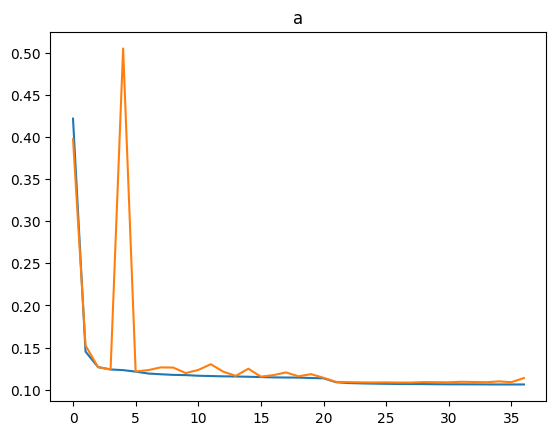

In [7]:
feat = "a"

model_name=f'predictor_{feat}_full_150'
# resnet34 / Scheduler / L1Loss 

model = resnet34_andi(output_dim=1, output_num=1, problem_type="a")

criterion = nn.L1Loss()

train_dataloader = train_dataloader_dict["a"]
valid_dataloader = valid_dataloader_dict["a"]



model, total_train_loss, total_valid_loss = train(model, train_dataloader, valid_dataloader,
                                                  criterion, 
                                                  # optimizer=optimizer, scheduler=scheduler,
                                                  num_epochs=num_epochs, device=device,  model_name=model_name,
                                                  tag=f"{feat}")
if os.path.exists(f"./model/loss/{model_name}_{feat}.npy") and total_train_loss is None:
    total_train_loss, total_valid_loss = np.load(f"./model/loss/{model_name}_{feat}.npy")
else:
    np.save(f"./model/loss/{model_name}_{feat}.npy", np.array([total_train_loss, total_valid_loss]))

print(np.argmin(total_valid_loss), np.min(total_valid_loss))


plt.plot(total_train_loss)
plt.plot(total_valid_loss)
plt.title(f"{feat}")
plt.show()
# plt.savefig("a_loss.png")

# Dataset Preparation : Diffusion Coefficient

In [8]:
X_dict = {f"{feat}":[] for feat in ["feat"]}
y_dict = {f"{feat}":[] for feat in ["k"]}

for i in tqdm(range(dataset_size)):

    X = np.load(f"./ds_single/ds_{i}.npy", allow_pickle=True)
    y = np.load(f"./ds_single/ds_label_{i}.npy", allow_pickle=True)

    ### TO Tensor
    X = torch.Tensor(X).squeeze().unsqueeze(axis=2).type(torch.Tensor)
    
    y = torch.Tensor(y[:,1])
    
    X_dict["feat"].append(X)
    y_dict["k"].append(y)

train_dataloader_dict = {f"{feat}":[] for feat in ["k"]}
valid_dataloader_dict = {f"{feat}":[] for feat in ["k"]}

g = torch.Generator()
g.manual_seed(42)

for feat in ["k"]:
    X = X_dict["feat"]
    y = y_dict[feat]
    X = torch.cat(X)
    y = torch.cat(y)
    dataset = AnDiDataset(X, y)

    # ## split
    train_set, val_set = torch.utils.data.random_split(dataset, [0.7, 0.3], generator=g)
    
    train_loader = DataLoader(train_set, batch_size=256, collate_fn=collate_fn, generator=g, shuffle=True)
    
    valid_loader = DataLoader(val_set, batch_size=64, collate_fn=collate_fn, generator=g, shuffle=True)

    train_dataloader_dict[f"{feat}"] = train_loader
    valid_dataloader_dict[f"{feat}"] = valid_loader

del X, y
import gc
gc.collect()

100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


4055

# Model Training : Diffusion Coefficient
## Default setting: resnet34(for andi) + custom warmstart scheduler + MSLELoss

Best Model Exist
49 0.15162916361411488


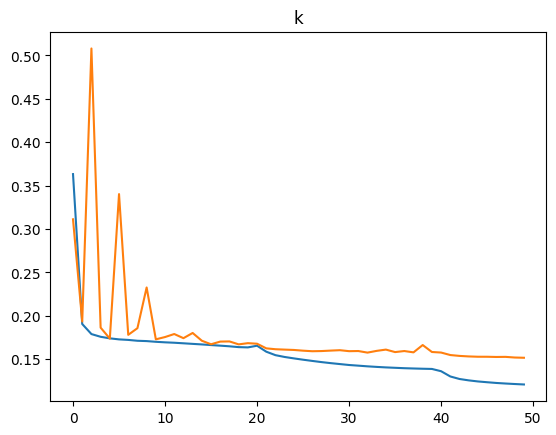

In [9]:
feat = "k"

model_name=f'predictor_{feat}_full_150'
# resnet34 / Scheduler / MSELELoss

model = resnet34_andi(output_dim=1, output_num=1, problem_type="k")

def MSLELoss(outputs, labels):
    return torch.sqrt(torch.mean((torch.log(outputs+1)-torch.log(labels+1))**2))
criterion = MSLELoss

train_dataloader = train_dataloader_dict["k"]
valid_dataloader = valid_dataloader_dict["k"]


model, total_train_loss, total_valid_loss = train(model, train_dataloader, valid_dataloader,
                                                  criterion, 
                                                  # optimizer=optimizer, scheduler=scheduler,
                                                  num_epochs=num_epochs, device=device,  model_name=model_name,
                                                  tag=f"{feat}")
if os.path.exists(f"./model/loss/{model_name}_{feat}.npy") and total_train_loss is None:
    total_train_loss, total_valid_loss = np.load(f"./model/loss/{model_name}_{feat}.npy")
else:
    np.save(f"./model/loss/{model_name}_{feat}.npy", np.array([total_train_loss, total_valid_loss]))

print(np.argmin(total_valid_loss), np.min(total_valid_loss))


plt.plot(total_train_loss)
plt.plot(total_valid_loss)
plt.title(f"{feat}")
plt.show()
# plt.savefig("k_loss.png")

# Dataset Preparation : Diffusion State

In [10]:
X_dict = {f"{feat}":[] for feat in ["feat"]}
y_dict = {f"{feat}":[] for feat in ["s"]}

for i in tqdm(range(dataset_size)):

    X = np.load(f"./ds_single/ds_{i}.npy", allow_pickle=True)
    y = np.load(f"./ds_single/ds_label_{i}.npy", allow_pickle=True)

    ### TO Tensor
    X = torch.Tensor(X).squeeze().unsqueeze(axis=2).type(torch.Tensor)
    
    y = torch.Tensor(y[:,3]).to(torch.long)
    
    X_dict["feat"].append(X)
    y_dict["s"].append(y)    

train_dataloader_dict = {f"{feat}":[] for feat in ["s"]}
valid_dataloader_dict = {f"{feat}":[] for feat in ["s"]}

g = torch.Generator()
g.manual_seed(42)

for feat in ["s"]:
    X = X_dict["feat"]
    y = y_dict[feat]
    X = torch.cat(X)
    y = torch.cat(y)
    dataset = AnDiDataset(X, y)

    # split
    train_set, val_set = torch.utils.data.random_split(dataset, [0.7, 0.3], generator=g)
    
    train_loader = DataLoader(train_set, batch_size=256, collate_fn=collate_fn, generator=g, shuffle=True)
    
    valid_loader = DataLoader(val_set, batch_size=64, collate_fn=collate_fn, generator=g, shuffle=True)

    train_dataloader_dict[f"{feat}"] = train_loader
    valid_dataloader_dict[f"{feat}"] = valid_loader

del X, y
import gc
gc.collect()

100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


3607

# Model Training : Diffusion State
## Default setting: resnet34(for andi) + custom warmstart scheduler + CrossEntropyLoss

Best Model Exist
26 0.17138678006320804


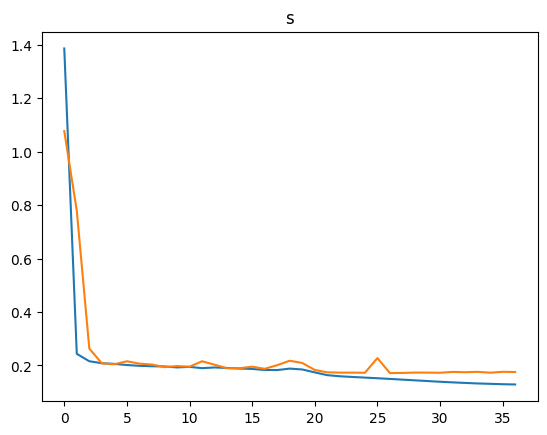

In [12]:
feat = "s"

model_name=f'predictor_{feat}_full_150'
# resnet34 / Scheduler / FocalLoss()

model = resnet34_andi(output_dim=4, output_num=1, problem_type="s")

criterion = nn.CrossEntropyLoss()


train_dataloader = train_dataloader_dict["s"]
valid_dataloader = valid_dataloader_dict["s"]



model, total_train_loss, total_valid_loss = train(model, train_dataloader, valid_dataloader,
                                                  criterion,  clf=True,
                                                  # optimizer=optimizer, scheduler=scheduler,
                                                  num_epochs=num_epochs, device=device,  model_name=model_name,
                                                  tag=f"{feat}")
if os.path.exists(f"./model/loss/{model_name}_{feat}.npy") and total_train_loss is None:
    total_train_loss, total_valid_loss = np.load(f"./model/loss/{model_name}_{feat}.npy")
else:
    np.save(f"./model/loss/{model_name}_{feat}.npy", np.array([total_train_loss, total_valid_loss]))

print(np.argmin(total_valid_loss), np.min(total_valid_loss))


plt.plot(total_train_loss)
plt.plot(total_valid_loss)
plt.title(f"{feat}")
plt.show()
# plt.savefig("s_loss.png")